In [311]:
# jupyter setup for reloading modules
# %load_ext autoreload
# %autoreload 2


In [332]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import sqlite3
from paths import PF_DB_PATH, DATA_DIR, AUS_PATH
from IPython.display import Markdown as md
from IPython.display import display
import os

DEBUG = True
PALETTE_TWO_COLOR = ['#3891ff','#c0cbeb']

In [313]:
def dist(lat1, lon1, lat2, lon2):
    # calculate distance between two coordinates
    return np.sqrt((lat1 - lat2) ** 2 + (lon1 - lon2) ** 2) * 60 * 1.852


In [314]:
def display_list(lst: list, sep=", ") -> str:
    # join list items to return a merged str for display
    return sep.join(lst)


def debug(df):
    # display df only in debug mode
    # - hide df printout when exporting html
    if DEBUG:
        display(df)


def decluter(
    ax,
    show_spines=False,
    show_xaxis=False,
    show_yaxis=False,
    xlabel=None,
    ylabel=None,
    title=None,
    x_use_million=False,
    x_use_unit=None,
    y_use_million=False,
    y_use_unit=None,
):
    # declutter chart by removing unneccessary elements
    # remove spines from chart
    ax.spines["top"].set_visible(show_spines)
    ax.spines["right"].set_visible(show_spines)
    ax.spines["bottom"].set_visible(show_spines)
    ax.spines["left"].set_visible(show_spines)
    # remove x axis
    ax.xaxis.set_visible(show_xaxis)
    # handle x axis labels
    ax.set_xlabel(xlabel)
    # format axis
    if x_use_million:
        ax.xaxis.set_major_formatter(lambda x, pos: f"{x/1e6:.1f}M")
    if x_use_unit:
        ax.xaxis.set_major_formatter(lambda x, pos: f"{x} {x_use_unit}")

    # remove y axis
    ax.yaxis.set_visible(show_yaxis)
    # handle y axis label
    ax.set_ylabel(ylabel)
    # format axis
    if y_use_million:
        ax.yaxis.set_major_formatter(lambda x, pos: f"{x/1e6:.1f}M")
    if y_use_unit:
        ax.yaxis.set_major_formatter(lambda x, pos: f"{x} {y_use_unit}")

    # set title
    ax.set_title(title, loc="left")

    # declutter legend
    legend = ax.get_legend()
    if legend:
        legend.get_frame().set_linewidth(0)
        legend.set_title(None)

    return ax


# Dataset
Data source: https://www.pricefinder.com.au/

This dataset was downloaded as separated `.xlsx` files, which were then merged into a single SQLite database. The SQL database consists of 2 tables:

In [315]:
con = sqlite3.connect(PF_DB_PATH)
raw_records = pd.read_sql_query("SELECT * FROM record", con)
raw_property = pd.read_sql_query("SELECT * FROM property", con)


In [316]:
md(
    f"""
1. records\n
    This table contains {raw_records.shape[0]:,} property sales records, each record contains the following data:
    * `id`: unique identification of the sales record, formed by merging address, postcode and sale date
    * `record_date`: date of sale (from {raw_records.record_date.min()} to {raw_records.record_date.max()})
    * `price`: final sale price
    * `sale_type`: type of sale ({display_list(raw_records.sale_type.unique().tolist())})
    * `prop_id`: id of the property, formed by merging address and postcode
    * `property_type`: type of property ({display_list(raw_records.property_type.unique().tolist())})
    * `bedrooms`: number of bedrooms
    * `bathrooms`: number of bathrooms
    * `carparks`: number of car parks
2. property\n
    This table contains {raw_property.shape[0]:,} properties that have associated sales record(s), each property details consist of the following data:
    * `address`: address with postcode attached, act as unique identification
    * `street`: street name
    * `locality`: suburb name ({raw_property.locality.nunique()} in total)
    * `postcode`: postcode ({raw_property.postcode.nunique()} in total)
    * `land_area`: land area
"""
)



1. records

    This table contains 731,552 property sales records, each record contains the following data:
    * `id`: unique identification of the sales record, formed by merging address, postcode and sale date
    * `record_date`: date of sale (from 2000-01-05 to 2022-01-04)
    * `price`: final sale price
    * `sale_type`: type of sale (Agents Advice - Sale, Normal Sale, Multi-Sale, Part Sale, Unknown)
    * `prop_id`: id of the property, formed by merging address and postcode
    * `property_type`: type of property (Commercial, Unit, Other, House, Vacant Land, Industrial)
    * `bedrooms`: number of bedrooms
    * `bathrooms`: number of bathrooms
    * `carparks`: number of car parks
2. property

    This table contains 455,865 properties that have associated sales record(s), each property details consist of the following data:
    * `address`: address with postcode attached, act as unique identification
    * `street`: street name
    * `locality`: suburb name (844 in total)
    * `postcode`: postcode (312 in total)
    * `land_area`: land area


In [317]:
debug(raw_records.describe(include="all"))
debug(raw_property.describe(include="all"))


,id,record_date,price,sale_type,prop_id,property_type,bedrooms,bathrooms,carparks
count,731552,731552,7.315520e+05,731552,731552,731552,731552.000000,731552.000000,731552.000000
unique,731552,8020,NaN,5,455865,6,NaN,NaN,NaN
top,"SUITE 311/368 SUSSEX ST, 2000_2021-12-16 00:00:00",2021-06-05,NaN,Normal Sale,"81 COURALLIE AVE, 2140",House,NaN,NaN,NaN
freq,1,457,NaN,712227,250,349058,NaN,NaN,NaN
mean,NaN,NaN,8.016123e+05,NaN,NaN,NaN,2.941512,1.758117,1.502566
std,NaN,NaN,2.019461e+06,NaN,NaN,NaN,54.283706,54.234449,2.211600
min,NaN,NaN,0.000000e+00,NaN,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,3.420000e+05,NaN,NaN,NaN,2.000000,1.000000,1.000000
50%,NaN,NaN,5.600000e+05,NaN,NaN,NaN,3.000000,2.000000,1.000000
75%,NaN,NaN,8.910000e+05,NaN,NaN,NaN,4.000000,2.000000,2.000000


,address,street,locality,postcode,land_area
count,455865,455865,455865,455865.000000,4.232550e+05
unique,455865,21958,844,NaN,NaN
top,"SUITE 311/368 SUSSEX ST, 2000",PACIFIC HWY,MOSMAN,NaN,NaN
freq,1,3755,2814,NaN,NaN
mean,NaN,NaN,NaN,2152.094122,3.828190e+03
std,NaN,NaN,NaN,79.614767,4.209191e+05
min,NaN,NaN,NaN,2000.000000,0.000000e+00
25%,NaN,NaN,NaN,2089.000000,4.740000e+02
50%,NaN,NaN,NaN,2147.000000,6.890000e+02
75%,NaN,NaN,NaN,2216.000000,1.170000e+03


# Data Cleaning

In [318]:
# raw dataframe
df_raw = pd.merge(
    raw_records, raw_property, left_on="prop_id", right_on="address", how="left"
).drop(columns=["prop_id"])

# filtered dataframe
last_record_date = "2021-12-31"
df_clean = df_raw.query(
    f"0<=bedrooms<=5 & 0<bathrooms<=5 & 0<=carparks <=3 & price >1000"
)
df_clean = df_clean[df_clean.record_date <= last_record_date]
df_clean["year"] = pd.DatetimeIndex(df_clean.record_date).year


In [319]:
md(
    f"""
There is no missing values in both tables. For `records`, unusually high number of bedrooms, bathrooms and car parks were found, possible due to the sale of buildings as a whole. For normal household, only properties with maximum 5 bedrooms/bathrooms and 3 car parks were considered.

On the other hand, it was noticed that some records show abnormally low prices. These records (specifically, all records with price less than $1,000) were removed from the analysis.

Also, to aid yearly aggregation, a `year` column was generated from `record_date`. It should be noted that only sales records on or before {last_record_date} were considered to ensure accuracy of annual statistics.

Consequently, a combined dataset was then formed by merging the two tables with left join on `records`. The final dataset for analysis consists of {df_clean.shape[0]:,} records ({df_clean.shape[0]/df_raw.shape[0]:.0%} of available records).

"""
)



There is no missing values in both tables. For `records`, unusually high number of bedrooms, bathrooms and car parks were found, possible due to the sale of buildings as a whole. For normal household, only properties with maximum 5 bedrooms/bathrooms and 3 car parks were considered.

On the other hand, it was noticed that some records show abnormally low prices. These records (specifically, all records with price less than $1,000) were removed from the analysis.

Also, to aid yearly aggregation, a `year` column was generated from `record_date`. It should be noted that only sales records on or before 2021-12-31 were considered to ensure accuracy of annual statistics.

Consequently, a combined dataset was then formed by merging the two tables with left join on `records`. The final dataset for analysis consists of 641,588 records (88% of available records).



In [320]:
debug(raw_records.isna().sum())
debug(raw_property.isna().sum())
debug(df_clean.describe(include="all").style.format(dict(price="{:,.0f}")))


id               0
record_date      0
price            0
sale_type        0
prop_id          0
property_type    0
bedrooms         0
bathrooms        0
carparks         0
dtype: int64

address          0
street           0
locality         0
postcode         0
land_area    32610
dtype: int64

,id,record_date,price,sale_type,property_type,bedrooms,bathrooms,carparks,address,street,locality,postcode,land_area,year
count,641588,641588,"641,588",641588,641588,641588.000000,641588.000000,641588.000000,641588,641588,641588,641588.000000,590382.000000,641588.000000
unique,641588,8006,nan,5,6,nan,nan,nan,413923,21305,829,nan,nan,nan
top,"3708/343-357 PITT ST, 2000_2021-12-14 00:00:00",2021-06-05,nan,Normal Sale,Unit,nan,nan,nan,"81 COURALLIE AVE, 2140",PACIFIC HWY,CAMPERDOWN,nan,nan,nan
freq,1,428,nan,629621,332896,nan,nan,nan,247,6095,4114,nan,nan,nan
mean,nan,nan,"829,704",nan,nan,2.737126,1.614366,1.361282,nan,nan,nan,2149.246400,5531.859969,2010.971758
std,nan,nan,"1,937,089",nan,nan,1.036375,0.698861,0.672205,nan,nan,nan,80.515402,663394.783778,6.364510
min,nan,nan,"1,050",nan,nan,0.000000,1.000000,0.000000,nan,nan,nan,2000.000000,0.000000,2000.000000
25%,nan,nan,"385,000",nan,nan,2.000000,1.000000,1.000000,nan,nan,nan,2087.000000,465.000000,2006.000000
50%,nan,nan,"590,000",nan,nan,3.000000,2.000000,1.000000,nan,nan,nan,2144.000000,701.000000,2012.000000
75%,nan,nan,"900,000",nan,nan,3.000000,2.000000,2.000000,nan,nan,nan,2213.000000,1393.000000,2016.000000


Further analysis suggested that most records were `Normal Sales` of either `House` or `Unit` properties. For simplicity and sake of interest, only these records were considered.

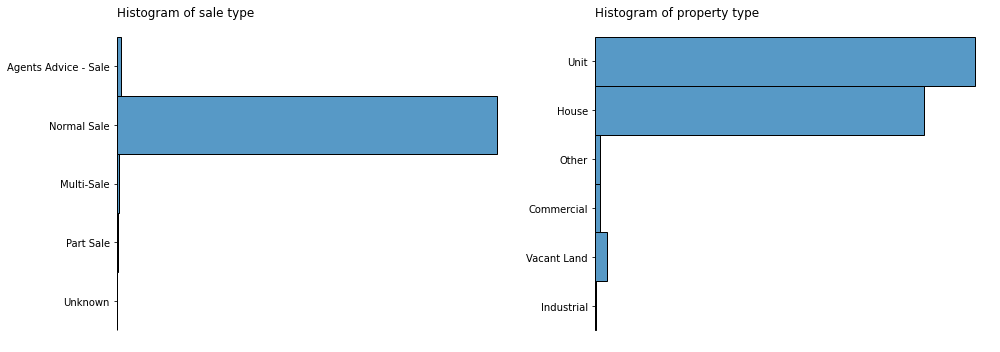

In [321]:
nrow, ncol = 1, 2
fig, axs = plt.subplots(nrow, ncol, figsize=(ncol * 7, nrow * 5))
axs = iter(axs.ravel())

# sale type
ax = next(axs)
sns.histplot(data=df_clean, y="sale_type", ax=ax)
decluter(ax, show_yaxis=True, title="Histogram of sale type")

# property type
ax = next(axs)
sns.histplot(data=df_clean, y="property_type", ax=ax)
decluter(ax, show_yaxis=True, title="Histogram of property type")

# fig config
fig.tight_layout()


For sale prices, a small portion of properties were sold in high value. To focus on properties of affordable range, only records with sale price below $3,000,000 were considered.

In [322]:
# filter out selected sale_type and property_type
df_sel = df_clean[
    (df_clean.sale_type == "Normal Sale")
    & (df_clean.property_type.isin(["Unit", "House"]))
]

df = df_sel.query("price <= 3e6")


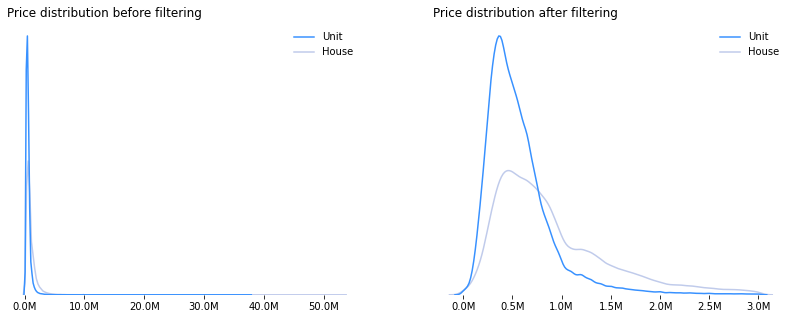

In [333]:
nrow, ncol = 1, 2
fig, axs = plt.subplots(nrow, ncol, figsize=(ncol * 7, nrow * 5))
axs = iter(axs.ravel())


def plot_dist(df, ax, title):
    sns.kdeplot(
        data=df,
        x="price",
        hue="property_type",
        ax=ax,
        palette= PALETTE_TWO_COLOR
    )
    decluter(ax, title=title, show_xaxis=True, x_use_million=True)


plot_dist(df_sel, next(axs), "Price distribution before filtering")
plot_dist(df, next(axs), "Price distribution after filtering")


In [324]:
debug(df.sale_type.unique())
debug(df.property_type.unique())


array(['Normal Sale'], dtype=object)

array(['Unit', 'House'], dtype=object)

In [325]:
# export as csv
df.to_csv(os.path.join(DATA_DIR, "dataset.csv"), index=False)


In summary, the following criterias were applied:

- sales record date: on or before 2021-12-31
- number of bedrooms: 0 to 5
- number of bathrooms: 1 to 5
- number of car parks: 0 to 3
- sale price: $1,000 to $3,000,000

In [326]:
md(
    f"""
The final dataset therefore contains {df.shape[0]:,} records ({df.shape[0]/df_raw.shape[0]:.0%} of the raw data).
"""
)



The final dataset therefore contains 600,451 records (82% of the raw data).


# Analysis

### General price trend

In [327]:
def get_median(df):
    # median by property type and year
    df_med = (
        df.drop(columns=["postcode"])
        .groupby(["property_type", "year"])
        .median()
        .reset_index()
    )
    # add rate of change column
    df_med["price_change"] = df_med.groupby(["property_type"]).price.diff() / df_med.price
    df_med.year = df_med.year.astype(int)
    return df_med
df_med= get_median(df)
debug(df_med.head())


,property_type,year,price,bedrooms,bathrooms,carparks,land_area,price_change
0,House,2000,328375.0,3.0,2.0,1.0,663.0,NaN
1,House,2001,372000.0,3.0,2.0,1.0,600.0,0.117272
2,House,2002,450000.0,3.0,2.0,1.0,600.0,0.173333
3,House,2003,528000.0,3.0,2.0,1.0,600.0,0.147727
4,House,2004,555000.0,3.0,2.0,1.0,604.0,0.048649


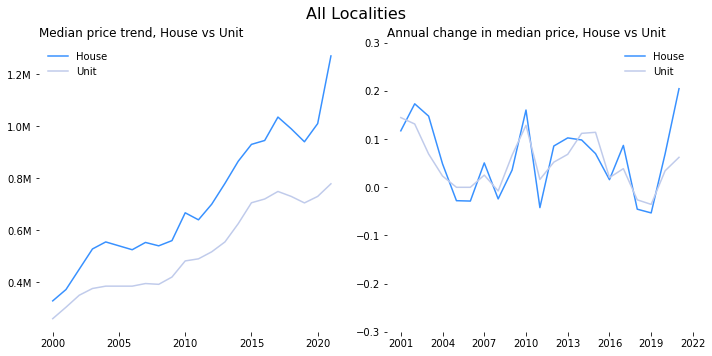

In [334]:
def plot_annual_trend(df, title):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs = iter(axs.ravel())
    ax = next(axs)
    sns.lineplot(
        data=df,
        x="year",
        y="price",
        hue="property_type",
        ax=ax,
        palette=PALETTE_TWO_COLOR,
    )
    decluter(
        ax,
        title="Median price trend, House vs Unit",
        show_xaxis=True,
        show_yaxis=True,
        y_use_million=True,
    )

    ax = next(axs)
    sns.lineplot(
        data=df,
        x="year",
        y="price_change",
        hue="property_type",
        ax=ax,
        palette=PALETTE_TWO_COLOR,
    )
    decluter(
        ax,
        title="Annual change in median price, House vs Unit",
        show_xaxis=True,
        show_yaxis=True,
    )
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylim(-0.3, 0.3)

    fig.tight_layout()
    fig.suptitle(title, size=16)
    fig.subplots_adjust(top=0.88)
    return fig


_ = plot_annual_trend(df_med, "All Localities")


### Price trend by suburbs

In [329]:
# suburb coordinates
suburb_coord = pd.read_csv(os.path.join(AUS_PATH, "nsw_suburb_coord.csv"))
# calculate distance from CBD
CBD_COORD = (-33.8708, 151.2073)
suburb_coord["cbd_dist"] = suburb_coord.apply(
    lambda row: dist(row["lat"], row["lon"], CBD_COORD[0], CBD_COORD[1]), axis=1
)

# data grouped by suburb
df_sub = (
    df.groupby(["locality", "postcode", "property_type", "year"]).median().reset_index()
)
# merge to get coordinates
df_sub = df_sub.merge(suburb_coord, on="locality")
debug(suburb_coord.head())
debug(df_sub.head())


,locality,lat,lon,cbd_dist
0,DAWES POINT,-33.857222,151.206776,1.509879
1,SYDNEY,-33.869844,151.208285,0.152520
2,HAYMARKET,-33.881441,151.204452,1.224013
3,MILLERS POINT,-33.859913,151.204127,1.260095
4,THE ROCKS,-33.859992,151.208322,1.206338


,locality,postcode,property_type,year,price,bedrooms,bathrooms,carparks,land_area,lat,lon,cbd_dist
0,ABBOTSBURY,2176,House,2000,266000.0,4.0,2.0,2.0,697.0,-33.869285,150.866703,37.847524
1,ABBOTSBURY,2176,House,2001,403000.0,4.5,2.0,2.0,667.0,-33.869285,150.866703,37.847524
2,ABBOTSBURY,2176,House,2002,437500.0,4.0,2.0,2.0,600.5,-33.869285,150.866703,37.847524
3,ABBOTSBURY,2176,House,2003,470500.0,4.0,2.0,1.0,634.0,-33.869285,150.866703,37.847524
4,ABBOTSBURY,2176,House,2005,480000.0,4.0,2.0,2.0,699.0,-33.869285,150.866703,37.847524


<AxesSubplot:title={'left':'2021 median price against distance from CBD'}>

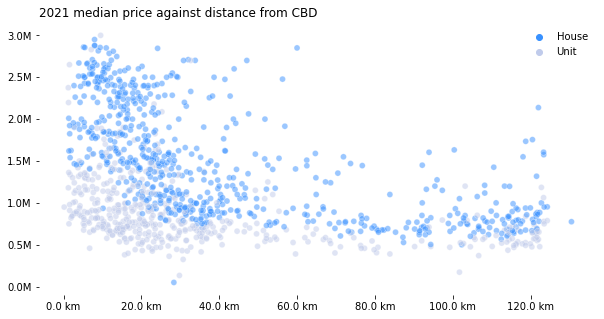

In [335]:
fig, ax = plt.subplots(figsize=(10, 5))
year = 2021
max_dist = 150
sns.scatterplot(
    data=df_sub.query(f"year=={year} & cbd_dist<={max_dist}"),
    x="cbd_dist",
    y="price",
    hue="property_type",
    alpha=0.5,
    ax=ax,
    palette=PALETTE_TWO_COLOR,
)
decluter(
    ax,
    show_xaxis=True,
    show_yaxis=True,
    y_use_million=True,
    title=f"{year} median price against distance from CBD",
    x_use_unit="km",
)


In [331]:
bin_edges = [0, 10, 20, 30, 40, 60, 100]
labels = [f"{ed} km" for ed in bin_edges[1:]] + [f"{bin_edges[-1]}+ km"]
df_sub["dist_bin"] = pd.cut(df_sub.cbd_dist, bins=bin_edges + [np.inf], labels=labels)
debug(df_sub.dist_bin.unique())


['40 km', '10 km', '100+ km', '100 km', '30 km', '20 km', '60 km']
Categories (7, object): ['10 km' < '20 km' < '30 km' < '40 km' < '60 km' < '100 km' < '100+ km']

<AxesSubplot:title={'left':'2021 median price against distance to CBD'}>

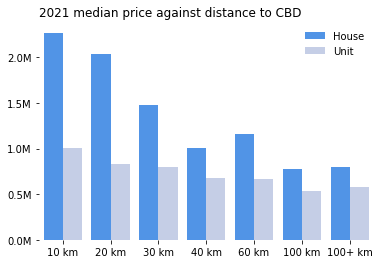

In [336]:
fig, ax = plt.subplots()
year = 2021
sns.barplot(
    data=df_sub.query(f"year=={year}")
    .groupby(["property_type", "dist_bin"])
    .median()
    .reset_index(),
    x="dist_bin",
    y="price",
    ax=ax,
    hue="property_type",
    palette=PALETTE_TWO_COLOR,
)
decluter(
    ax,
    show_yaxis=True,
    show_xaxis=True,
    y_use_million=True,
    title=f"{year} median price against distance to CBD",
)


In [257]:
df_sub


,locality,property_type,year,price,bedrooms,bathrooms,carparks,land_area,lat,lon,cbd_dist,dist_bin
0,ABBOTSBURY,House,2000,266000.0,4.0,2.0,2.0,697.0,-33.869285,150.866703,37.847524,40 km
1,ABBOTSBURY,House,2001,403000.0,4.5,2.0,2.0,667.0,-33.869285,150.866703,37.847524,40 km
2,ABBOTSBURY,House,2002,437500.0,4.0,2.0,2.0,600.5,-33.869285,150.866703,37.847524,40 km
3,ABBOTSBURY,House,2003,470500.0,4.0,2.0,1.0,634.0,-33.869285,150.866703,37.847524,40 km
4,ABBOTSBURY,House,2005,480000.0,4.0,2.0,2.0,699.0,-33.869285,150.866703,37.847524,40 km
...,...,...,...,...,...,...,...,...,...,...,...,...
23413,ZETLAND,Unit,2017,940500.0,2.0,2.0,1.0,105.5,-33.907662,151.208218,4.097410,10 km
23414,ZETLAND,Unit,2018,936000.0,2.0,2.0,1.0,108.0,-33.907662,151.208218,4.097410,10 km
23415,ZETLAND,Unit,2019,885000.0,2.0,2.0,1.0,130.5,-33.907662,151.208218,4.097410,10 km
23416,ZETLAND,Unit,2020,910000.0,2.0,2.0,1.0,109.0,-33.907662,151.208218,4.097410,10 km


### Suburbs closed to CBD (within 40km)

In [304]:
# list of suburbs within 40km of CBD
cbd_subs= suburb_coord.query('cbd_dist<=40').locality.tolist()
# data of sales closed to CBD
df_cbd = df[df.locality.isin(cbd_subs)]
# median by property type and year
df_cbd_med = get_median(df_cbd)
debug(df_cbd_med.head())

,property_type,year,price,bedrooms,bathrooms,carparks,land_area,price_change
0,House,2000,360000.0,3.0,2.0,1.0,675.0,NaN
1,House,2001,427500.0,3.0,2.0,1.0,606.0,0.157895
2,House,2002,516000.0,3.0,2.0,1.0,603.0,0.171512
3,House,2003,595750.0,3.0,2.0,1.0,603.0,0.133865
4,House,2004,630000.0,3.0,2.0,2.0,606.0,0.054365


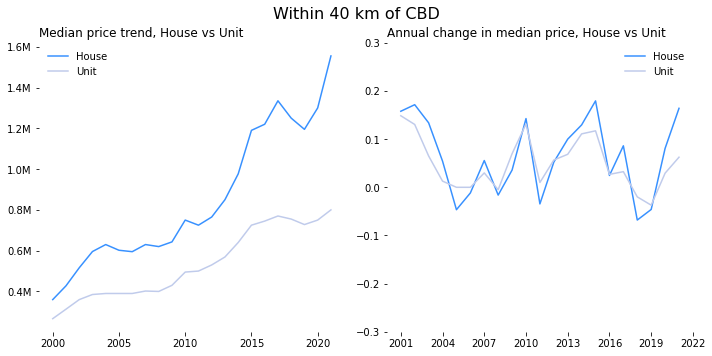

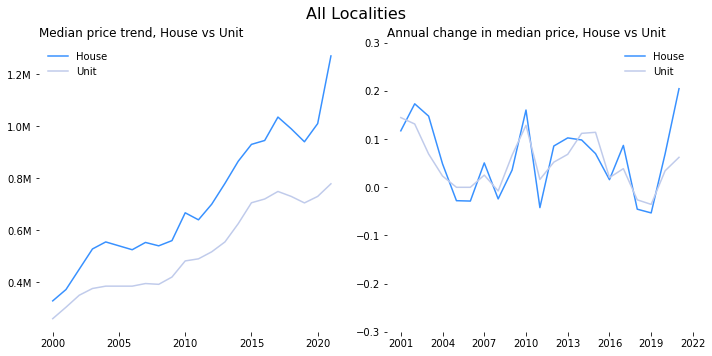

In [338]:
_=plot_annual_trend(df_cbd_med, title='Within 40 km of CBD')
_=plot_annual_trend(df_med, title='All Localities')